In [253]:
from dolfin import *
from matplotlib import pyplot as plt

In [254]:
length, depth = 300, 300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))

In [260]:
mat1_sub_domain = CompiledSubDomain("x[0]<=L/2",L=length)
mat2_sub_domain = CompiledSubDomain("x[0]>=L/2",L=length)

In [261]:
dim = mesh.topology().dim()
mf = MeshFunction("size_t",mesh,dim)

In [262]:
mat1_sub_domain.mark(mf,1)
mat2_sub_domain.mark(mf,2)

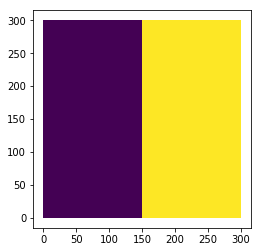

In [265]:
plot(mf)

## How to assign material properties to different subdomains?

Assigning material properties to different domains is a common task in finite element simulations using FEniCS. FEniCS provides a flexible way to handle complex geometries and define material properties on different regions of the mesh. To achieve this, we can use a `MeshFunction` to label different subdomains and then use `Measures` to integrate over these labeled subdomains. 

Here's a step-by-step guide on how to do this:

**Step 1: Install FEniCS**
Make sure you have FEniCS installed on your system. You can follow the instructions on the FEniCS website (https://fenicsproject.org/download/) for installation guidelines.

**Step 2: Import Required Libraries**
Start by importing the necessary FEniCS modules:

```python
from dolfin import *
```

**Step 3: Create the Mesh**
Generate or import the mesh that represents your geometry. For simplicity, let's assume you have already created the mesh and loaded it:

```python
# Replace 'mesh.xml' with the path to your mesh file
mesh = Mesh("mesh.xml")
```

**Step 4: Define Subdomains using `MeshFunction`**
Create a `MeshFunction` to label the different subdomains of your mesh. Each label corresponds to a specific material region or domain.

```python
# Create a MeshFunction with dimension 0 (cell-wise function) and integer data
subdomains = MeshFunction("size_t", mesh, mesh.dim())

# Define the subdomain regions by marking the cells with the corresponding material label
# For example, label 1 represents material 1, label 2 represents material 2, and so on
subdomain_1 = AutoSubDomain(lambda x, on_boundary: x[0] < 0.5 and x[1] < 0.5)
subdomain_2 = AutoSubDomain(lambda x, on_boundary: x[0] >= 0.5 and x[1] < 0.5)

# Mark subdomains on the MeshFunction using the defined subdomain regions
subdomain_1.mark(subdomains, 1)
subdomain_2.mark(subdomains, 2)
```

**Step 5: Define the Material Properties**
Now, define the material properties for each domain. For this example, we'll consider two materials (material 1 and material 2):

```python
# Define material properties for each domain
material_properties = {
    1: {"YoungsModulus": 1.0, "PoissonsRatio": 0.3},
    2: {"YoungsModulus": 2.0, "PoissonsRatio": 0.25}
}
```

**Step 6: Define the Finite Element Function Space**
Next, define the finite element function space. Choose the appropriate function space based on your problem, such as `VectorFunctionSpace` or `FunctionSpace`.

```python
# Define the function space based on the problem requirements
V = VectorFunctionSpace(mesh, "Lagrange", 1)
```

**Step 7: Define the Test and Trial Functions**
Define the test and trial functions in the chosen function space.

```python
# Define the test and trial functions
u = TrialFunction(V)
v = TestFunction(V)
```

**Step 8: Define the Material Property Expression**
To assign material properties to each domain, we need to create an expression that evaluates the material properties based on the `subdomains` value at each point in the mesh.

```python
# Define the material property expression based on subdomains
class MaterialProperties(Expression):
    def __init__(self, subdomains, properties, **kwargs):
        self.subdomains = subdomains
        self.properties = properties
        super().__init__(**kwargs)

    def eval_cell(self, values, x, cell):
        cell_id = cell.index()
        subdomain_id = self.subdomains[cell_id]
        properties = self.properties.get(subdomain_id, self.properties[1])
        values["E"] = properties["YoungsModulus"]
        values["nu"] = properties["PoissonsRatio"]

# Initialize the material property expression with the subdomains and material properties
material_expr = MaterialProperties(subdomains, material_properties, degree=0)

# Split the expression into its components for FEniCS to recognize it as a vector-valued expression
E, nu = split(material_expr)
```

**Step 9: Define the Strain and Stress Formulations**
Define the strain and stress formulations based on the material properties. You can use standard equations like Hooke's law to define these expressions.

```python
# Define the strain and stress formulations
I = Identity(V.cell().d)  # Identity tensor
strain = sym(grad(u))
stress = 2 * E * nu / (1 - nu) * strain + E / (1 + nu) * tr(strain) * I
```

**Step 10: Define the Variational Problem**
Define the variational problem by incorporating the strain and stress expressions.

```python
# Define the variational problem
a = inner(stress, grad(v)) * dx
L = Constant((0.0, 0.0)) * v * dx
```

**Step 11: Solve the Problem**
Finally, solve the variational problem to obtain the displacement field `u`.

```python
# Create the solution Function to store the results
u_sol = Function(V)

# Solve the variational problem
solve(a == L, u_sol)
```

That's it! You have now assigned material properties to different domains using `MeshFunction` and `Measures` in FEniCS. This approach allows you to perform finite element simulations on complex geometries with varying material properties efficiently.